# Heat Capacity of a Lithium-Ion cell

In this notebook we investigate the method proposed by Bryden et al (2018) to determine the specific capacity property $C_{p} \left[\frac{J}{K\cdot kg}\right]$ of a Lithium-Ion cell. 

Meterials used in the experiment:
- Cell cycler Arbin LBT21084
- Thermal Chamber Binder KB115
- Thermocouples (T-type)

This notebook is structured around three main topics:

1. Thermal model: simplified model derivation using SimPy, just to check for any typos or inconsistency in the equations;
2. Exploratory data analysis: here the experiments to measure internal cell heat generation and external thermal resistance using a cell cycler, thermocouples and a thermal chamber are explored, testing different things to see how it behaves;
3. Heat capacity and internal resistance calculations: straightforward simultaneous equation solved for two unknowns. 

# 1. Thermal model

Essentially the thermal model is needed to define which parameters we can measure and which variables we can calculate to find out the specific heat capacity $C_{p}$ of a given cell. This method take advantage of a lumped-parameter thermal model developed by Forgez et al (2010), in which the internal temperature of the battery is estimated based on it's surface temperature. In this model, heat transfer coefficient includes conduction, convection and radiation mechanisms. The general idea could be thought as:

1. Heat is generated in a single point (1) inside the cell, $\dot{Q}_{gen}[W]$;

2. Heat is transfered from point (1) which is at temperature $T_{1}[K]$ to to the cell surface (2) at $T_{s}[K]$; 

3. Heat is transfered from the cell surface (2) which is at $T_{s}[K]$ to to the ambient (3) at temperature $T_{a}[K]$.

Let's derive the equations of the thermal model using sympy:

In [1]:
import sympy as sp
from sympy import Derivative
sp.init_printing()

In [2]:
#defining symbols for symbolic manipulation:
Cp, Ta, Rin, Rout, t, A, h = sp.symbols('C_p, T_a, R_in, R_out, t, A, h')
#defining time dependent variables:
Ti, Ts, Qdot_gen= sp.symbols('T_i, T_s, \dot{Q}_{gen}', cls=sp.Function)
Ti = Ti(t)
Ts = Ts(t)
Qdot_gen = Qdot_gen(t)

If we perform a heat balance at the point inside the cell, we have heat being generated $\dot{Q}_{gen}$ minus the heat that flows to the cell surface. This phenomenon depends uppon the heat transfer coefficient $h\left[\frac{W}{K\cdot m^{2}}\right]$, the area $A[m^{2}]$ thorugh the heat is being trasfered and the difference between $T_{1}$ and $T_{s}$. Finally, this is related to the heat capacity $C_{p}$ and the rate at which temperature $T_{1}$ changes over time $\frac{dTi}{dt}$:

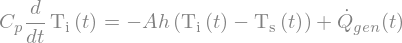

In [3]:
equation_1 = sp.Eq(Cp * sp.Derivative(Ti, t), (Qdot_gen - (h * A) * (Ti - Ts)))
equation_1

Because the area does not change throught the experiments, Brayden (2018) simplies Equation 1 using the inverse of internal thermal resistance $\frac{1}{R_{in}}\left[\frac{W}{K}\right]$ instead of $hA$ term, which lead us to Equation 2:

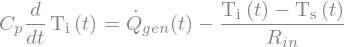

In [4]:
equation_2 = sp.Eq(Cp * sp.Derivative(Ti, t), (Qdot_gen - (1 / Rin) * (Ti - Ts)))
equation_2

Thermal resistance can be defined as how difficult is for heat to flow throught a material. Unfortunately it is not pratical to measure because it would imply placing a thermocouple inside the cell. To eliminate $R_{in}$ from Equation 2, a energy balance is performed at the surface of the cell:

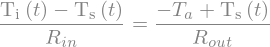

In [5]:
equation_3 = sp.Eq((1 / Rin) * (Ti - Ts), (1 / Rout) * (Ts - Ta))
equation_3

Isolating $T_{i}$ we have:

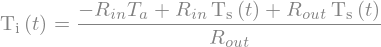

In [6]:
equation_4 = sp.Eq(Ti, sp.solve(equation_3, Ti)[0]) #sp.solve returns a list
equation_4 

Substituting $T_{1}$ into Equation 2 give us:

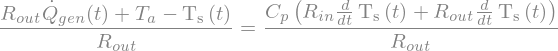

In [7]:
equation_5 = equation_2.subs(Ti, equation_4.rhs).simplify()
equation_5

which can be further manipulated as:

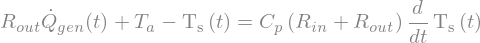

In [8]:
equation_6 = sp.Eq(equation_5.lhs * Rout, equation_5.rhs * Rout)
equation_6.simplify()

Finally, we can apply a forward Euler discretization to solve the differential equation:






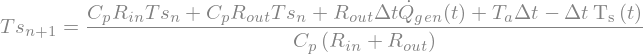

In [9]:
Ts_n, Ts_n_1, delta_t = sp.symbols('Ts_n, Ts_{n+1} \Delta{t}')
equation_7 = equation_6.subs(sp.Derivative(Ts, t), (Ts_n_1 - Ts_n)/delta_t)
equation_7 = sp.Eq(Ts_n_1, sp.solve(equation_7, Ts_n_1)[0]).simplify()
equation_7

# 2. Exploratory data analysis

In this section, experimental data is explored in different ways to see if we can get some insights and find possible issues of the methodology proposed applied to the data we have. 

Classes and methods were created to explore the data. All files can be found at: https://github.com/adrianoschommer/heat_capacity

For now, it's sufficient to say that the classes are divided into:
- DataParse() to read data and perform some data wrangling;
- DataSection() to split the data into initial_section and final_section with the aim to perform apply the proposed method itself.

Let's start by importing these classes from the GitHub repository and reading the files. We have two of them, one for the each equation that will be solved at the last part of this notebook:

In [10]:
import glob
glob.glob('data\\*.xlsx')

['data\\demo_data_Thermal_Char_25degC.xlsx',
 'data\\demo_data_Thermal_Char__25degC_80fan.xlsx']

In [11]:
from DataParse import *
from DataSection import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

raw_data = DataParse()
raw_data = raw_data.read_file(0)  # Loads the first file

data\demo_data_Thermal_Char_25degC.xlsx successfully loaded


If we plot voltage vs running test time, for example. We will see that the cycling does not start at the very beggining of the test because the cell is being conditioned to 50% of State of Charge (SOC):

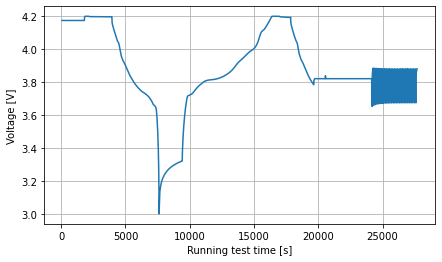

In [12]:
fig, ax1 = plt.subplots(figsize=(7, 4))
ax1.plot(raw_data['Test_Time(s)'], raw_data['Voltage(V)'])
ax1.set_ylabel('Voltage [V]')
ax1.set_xlabel('Running test time [s]')
ax1.grid()

For this reason we'll set only the final part of the raw data as our test data where we'll actually perform the analysis:

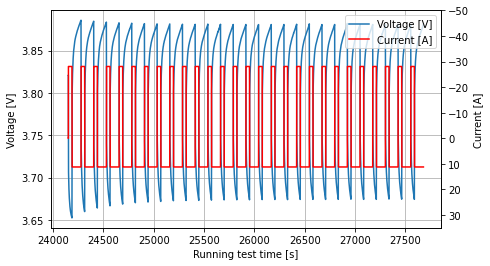

In [13]:
start_cycle_time = 24150
test_data = DataParse()
test_data = test_data.set_test_data(raw_data, start_cycle_time)
DataParse().plot_test_data(test_data)

## 2.1. initial and final sections

We should also split the data into the initial section and final section. This is needed because some of the calculations uses the steady state portion of the data while others uses the transient part:

- initial_section calculations:
    - internal thermal resistance
    - heat capacity

- final_section calculations:
    - external thermal resistance

We'll skip the details of the implementation to focus on the data analysis itself. It's suffient to say that the initial and final section are defined in terms of the surface temperature of the cell during the test. 

For this reason, we need to add a filtered data channel to smooth the temperature signal in order to avoid false triggering the thresholds due to the sinusoidal wave form of the the temperature signal (this occurs because of the high C-rates of charge / discharge the cell is being subjected to).

In [14]:
filter_window = 131
poly_fit_order = 1
# Adds filtered temperature channels:
test_data = DataParse().add_temperature_channels(test_data, filter_window,
                                          poly_fit_order)

# Sets steady-state prt of the data (final section)
final_section_data = DataSection().set_final_section(test_data, 0.3)

# calculates average surface temperature:
AVG_SURFACE_TEMP = DataSection().calculate_AVG_SURFACE_TEMP(final_section_data)

# Sets the transient section (initial) -> 95% of steady-state temperature
initial_section_data = DataSection().set_initial_section(test_data, 0.95,
                                                         AVG_SURFACE_TEMP)

AVG_SURFACE_TEMP = 29.238 [°C]


## 2.2. Internal heat generation

Internal heat generated by the cell is calculated by:

$\dot{Q}_{gen}	=RI^{2}$

Where $R[\Omega]$ is the eletrical resistance and $I[A]$ is the current passing through the cell. 

Joule heating is also proportional to the voltage drop across the cell (Equation [eq:ohmic_volt_drop]), where $V$ is the voltage of the cell and $V_{OCV}(SOC)$ is the open circuit voltage (OCV) as function of state of charge (SOC). The Equation above can be further manipulated as:

$\dot{Q}_{gen}	=RI^{2} =|(V-V_{OCV}(SOC))\cdot I|$

Note that the current absolute value are taking into account because heat is generated both in charge and discharge. 

Bryden (2018) proposes that the heat generated is calculate from the entire data, although the external thermal resistance is calculated only from the final section. For this reason, we'll calculate both for the entire test and final section to see the differences:

Entire test_data:
average Q_GEN = 1.333 [W]

final_section: 
average Q_GEN = 1.267 [W]


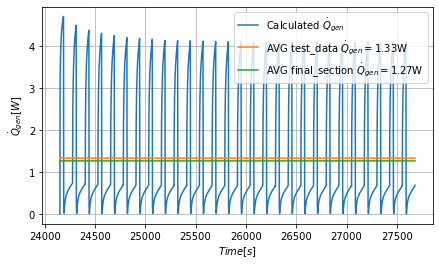

In [15]:
OCV = 3.82
print('Entire test_data:')
AVG_Q_GEN_test_data = DataParse().calculate_AVG_Q_GEN(test_data, 3.82)
print('\nfinal_section: ')
AVG_Q_GEN_final_section_data = DataParse().calculate_AVG_Q_GEN(
    final_section_data, 3.82)

data = test_data.copy()
data['AVG_Q_GEN_test_data'] = AVG_Q_GEN_test_data
data['AVG_Q_GEN_final_section_data'] = AVG_Q_GEN_final_section_data
data['Q_gen'] = abs((data['Voltage(V)'] - 3.82) * data['Current(A)'])

fig, ax1 = plt.subplots(figsize=(7,4))
ax1.plot(data['Test_Time(s)'], data['Q_gen'],
         label='Calculated $\dot{Q}_{gen}$')
ax1.plot(data['Test_Time(s)'], data['AVG_Q_GEN_test_data'],
         label='AVG test_data $\dot{Q}_{gen}=$' 
         + str(round(AVG_Q_GEN_test_data,2)) + 'W')
ax1.plot(data['Test_Time(s)'], data['AVG_Q_GEN_final_section_data'],
         label='AVG final_section $\dot{Q}_{gen}=$'
         + str(round(AVG_Q_GEN_final_section_data,2)) + 'W')
ax1.set_ylabel('$\dot{Q}_{gen} [W]$')
ax1.set_xlabel('$Time [s]$')
ax1.legend(loc = 'upper right')
ax1.grid()

We clear can see a considerable difference between these two approaches. The implications of this will be further analysed when we discuss the results in later secions.

## 2.3. External thermal resistance (final_section)

In order to calculate $R_{out}$, the cell is submited to cycles of charge/discharge pulses of $\pm5\%$ SOC at the maximum allowed C-rates. The cycle is performed until the heat generated by the cell reaches equilibrium state with the ambient. In other words, the surface temperature $T_{s}$ stops increasing and thus the derivative term $\frac{dT_{s}}{dt}$ reaches $\frac{dT_{s}}{dt}=0$ in Equation 6, which becomes: $R_{out}=\frac{(T_{s}-T_{a})}{\dot{Q}_{gen}}$

First, let's take a look at the entire test data to see how the temperatures look like:

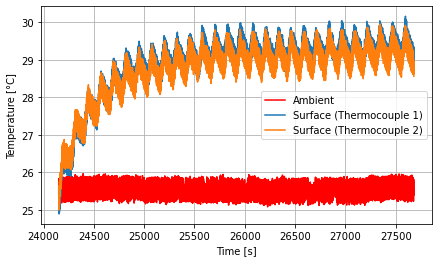

In [16]:
fig, ax1 = plt.subplots(figsize=(7,4))
ax1.plot(test_data['Test_Time(s)'], test_data['Aux_Temperature_3(C)'], 
         label='Ambient', color='r')
ax1.plot(test_data['Test_Time(s)'], test_data['Aux_Temperature_1(C)'],
         label='Surface (Thermocouple 1)')
ax1.plot(test_data['Test_Time(s)'], test_data['Aux_Temperature_2(C)'],
         label='Surface (Thermocouple 2)')
ax1.legend(loc=0)
ax1.set_ylabel('Temperature [°C]')
ax1.set_xlabel('Time [s]')
ax1.grid()

Now, let's arbitrarily consider the final 1/3 of the data as the portion of thermal stability. Certainly there is better ways to evaluate this, such as evaluating the derivatives of a moving average along the data. But for the sake of simplicity let's leave as it is to see how far we can get.

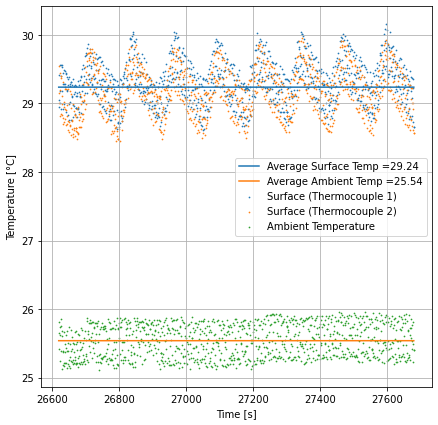

In [17]:
DataSection().plot_final_section(final_section_data)

### 2.3.1. Thermal stability

Is the system thermal stable? how to evaluate this? let's try to perform an analysis based on the derivative of the moving average of the temperature signal to see what happens:


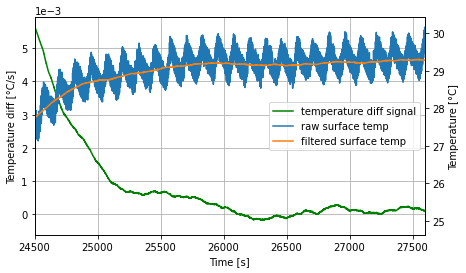

In [18]:
rolling_window = int(len(test_data) / 10)
temp_diff = pd.Series(np.diff(
    test_data['surface_temp_filtered'])).rolling(rolling_window).mean()
test_time = test_data['Test_Time(s)'].iloc[:-1]

fig, ax1 = plt.subplots(figsize=(7,4))
ax2 = ax1.twinx()
ax1.plot(test_time, temp_diff, color='g', label='temperature diff signal')
ax2.plot('Test_Time(s)', 'Aux_Temperature_1(C)', data=test_data, label='raw surface temp')
ax2.plot('Test_Time(s)','surface_temp_filtered', data=test_data, label='filtered surface temp')

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
ax1.set_xlabel('Time [s]')
ax1.set_ylabel('Temperature diff [°C/s]')
ax1.set_xlim([24500, 27600])
ax1.grid()
ax2.set_ylabel('Temperature [°C]')
ax2.legend(lines + lines2, labels + labels2, loc=5)


Is it good or bad? let's see what is the average diff for the last 500s, for example, and check how much temperature change we would have over 3600s (1h):

In [19]:
window_size = 500
AVG_diff_last_section = temp_diff[0:-window_size].mean()
print('Temperature diff is '  + str(round(AVG_diff_last_section,5)) 
      + ' [°C/s] for the last ' + str(window_size) + 's')
print('Temp change in 3600s would be: '
      + str(round(AVG_diff_last_section*3600,3)) + ' °C')

Temperature diff is 0.00086 [°C/s] for the last 500s
Temp change in 3600s would be: 3.083 °C


let us now expand the analysis of the window size from 100s to 1500s to see how this analysis behaves for a more comprehensive amount of data

Text(0, 0.5, 'Temperature increase / hour [°C/h]')

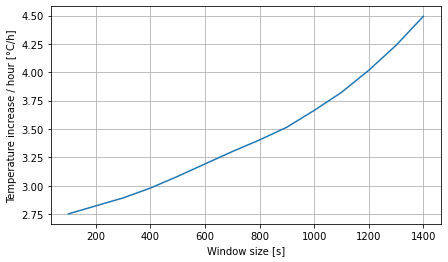

In [20]:
window_size = range(0, 1500, 100)
temp_change_3600s = []
for i in window_size:
    temp_change_3600s.append(temp_diff[0:-i].mean()*3600) 

fig, ax1 = plt.subplots(figsize=(7,4))
ax1.plot(window_size, temp_change_3600s)
ax1.grid()

ax1.set_xlabel('Window size [s]')
ax1.set_ylabel('Temperature increase / hour [°C/h]')

### 2.3.2. External thermal resistance calculation: raw data vs average values:

Should external thermal resistance (R_OUT) be calculated with raw data of temperatures and calculated heat generated (Q_GEN) and then average the value or we should use average temperatures and Q_GEN? Let's see what happens for the first case:

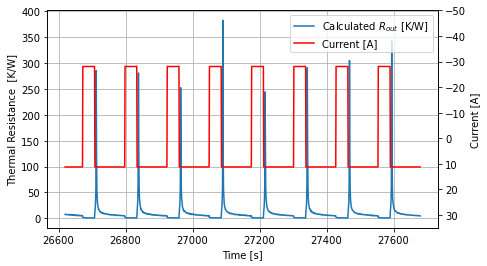

In [21]:
# There is no need to convert Ts_mean and Ta to Kelvin because it's a delta diference in the equation

data = final_section_data.copy()
# Thermocouple 01:
surface_temp_1 = data['Aux_Temperature_1(C)']
# Thermocouple 02:
surface_temp_2 = data['Aux_Temperature_2(C)']
# Thermocouple 03:
ambient_temp = data['Aux_Temperature_3(C)']
data['raw_Q_GEN'] = abs((data['Voltage(V)'] - OCV) * data['Current(A)'])
data['R_OUT'] = ((surface_temp_1 + surface_temp_2)/2 - ambient_temp) / data['raw_Q_GEN']

fig, ax1 = plt.subplots(figsize=(7, 4))
ax2 = ax1.twinx()
ax1.plot('Test_Time(s)', 'R_OUT', data=data, label='Calculated $R_{out}$ [K/W]')
ax2.plot('Test_Time(s)', 'Current(A)', data=data, label='Current [A]', color='r')

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.set_ylabel('Thermal Resistance  [K/W]')
ax1.set_xlabel('Time [s]')
ax1.grid()
ax2.set_ylim([35,-50])
ax2.set_ylabel('Current [A]')
ax2.legend(lines + lines2, labels + labels2, loc=0)

It does not seem to be correct. We can see that every time the current changes the sign, a peak occurs in the calculated R_OUT because I reaches 0. Let's take a closer look at what happens with each variable of the equation:

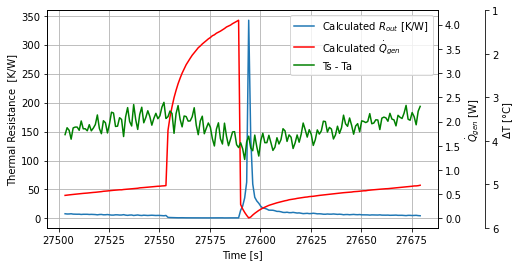

In [22]:
size_sample = 180
data = data.iloc[-size_sample:]
Ts_minus_Ta = ((surface_temp_1 + surface_temp_2)/2 - ambient_temp).iloc[-size_sample:]

fig, ax1 = plt.subplots(figsize=(7,4))
ax2 = ax1.twinx()
ax3 = ax1.twinx()

ax1.plot('Test_Time(s)', 'R_OUT', data=data, label='Calculated $R_{out}$ [K/W]')
ax2.plot('Test_Time(s)', 'raw_Q_GEN', data=data, label='Calculated $\dot{Q}_{gen}$', color='r')
ax3.plot(data['Test_Time(s)'], Ts_minus_Ta, label='Ts - Ta', color='g')

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines3, labels3 = ax3.get_legend_handles_labels()
ax1.set_xlabel('Time [s]')
ax1.grid()
ax1.set_ylabel('Thermal Resistance  [K/W]')
ax2.set_ylabel('$\dot{Q}_{gen}$ [W]')
ax2.legend(lines + lines2 + lines3, labels + labels2 + labels3, loc='upper right')
ax3.set_ylabel('ΔT [°C]') 
ax3.tick_params(axis='y')
ax3.spines["right"].set_position(("axes", 1.12))
ax3.set_ylim([6,1])

In fact the peak is due to I approaching zero value and by consequence Q_GEN approaches zero, which makes the External resistance peak at that point. Now let's investigate how this affect the average External resistance. The calculation below takes all raw data seen in the graphic above:

In [23]:
print('R_OUT from raw data = ' + str(round(data['R_OUT'].mean(),3)) + ' [K/W]')

R_OUT from raw data = 9.942 [K/W]


Now let's see what happens if instead of raw data we take the averaged temperatures and Q_GEN:

In [24]:
AVG_Q_GEN = DataParse().calculate_AVG_Q_GEN(test_data, 3.82)
R_OUT = DataSection().calculate_R_OUT(final_section_data, AVG_Q_GEN)

average Q_GEN = 1.333 [W]
R_OUT = 2.775 [K/W]


A huge difference. Indeed the calculated R_OUT from the averages is closer to the value we are expecting. The equation cannot handle properly Q_GEN approaching zero

## 2.4.  Internal thermal resistance and heat capacity (initial_section)

In order to calculate internal thermal resistance and heat capacity, we will have to take into consideration the initial part of the data where the system is not stable. For this we used a cutoff temperature before it reaches thermal stability, here we used 95% of the thermal stability temperature:

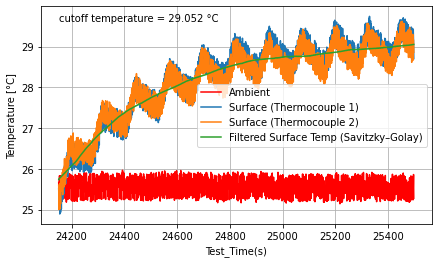

In [25]:
initial_section_data = DataSection().set_initial_section(test_data, 0.95, AVG_SURFACE_TEMP)
DataSection().plot_initial_section(initial_section_data)

### 2.4.1. Least squares optimization

In order to find the internal thermal resistance R_IN and the heat capacity $C_p$ we need to fit equation 7 into the surface temperature data. All parameters were calculated befor using final_section of the data except for R_IN and $C_p$. Because we have two unknows, we need two equations as well. That's why the experiments are run twice, only modifying the external thermal resistance by using a fan to blow air in the cell.

In this notebook we have used a least squares regression, but it could be any method. In terms of how the optimization method is performed, we could use raw temperature data or filtered data. Let's first see how it behaves using raw data:

In [26]:
ys = initial_section_data['Aux_Temperature_1(C)']
print('Cp(Rin + Rout) =', round(DataSection().optimize_equation(ys, initial_section_data, AVG_Q_GEN, R_OUT), 3))

Cp(Rin + Rout) = 389.104


and now using filtered data:

In [27]:
ys = initial_section_data['surface_temp_filtered']
print('Cp(Rin + Rout) =', round(DataSection().optimize_equation(ys, initial_section_data, AVG_Q_GEN, R_OUT), 3))

Cp(Rin + Rout) = 404.184


We can see a huge difference between both results. First, let's see if there is any local minimum to this equation. For this, we'll calculate Equation 7 passing a range of Cp(Rin + Rout) values and evaluate the RMSE against the filtered temperature:

min RMSE (filtered temp) = 0.0862
Cp(Rin + Rout) = 400
------------------------------------
min RMSE (raw temp) = 0.3219
Cp(Rin + Rout) = 400


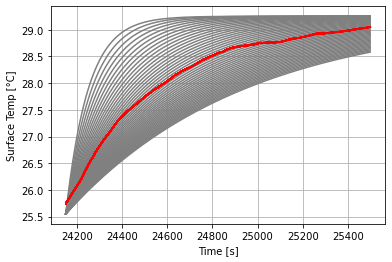

In [28]:
RMSE_filtered = []
RMSE_raw = []
i = -1
time_data = initial_section_data['Test_Time(s)']
temp_filtered = initial_section_data['surface_temp_filtered']
temp_raw = initial_section_data['surface_temp_average'] 
info_filtered = []
info_raw = []
DENOMINATOR = range(100,800,15)
for k in DENOMINATOR:
    i = i+1
    calculated_surface_temp = DataSection().calculate_surface_temp(k, initial_section_data, 
                                                                            AVG_Q_GEN, R_OUT)
    RMSE_filtered.append(np.sqrt(np.mean((calculated_surface_temp - temp_filtered)**2)))
    RMSE_raw.append(np.sqrt(np.mean((calculated_surface_temp - temp_raw)**2)))
    if RMSE_filtered[i] < RMSE_filtered[i-1]:
        info_filtered.append('min RMSE (filtered temp) = ' + str(round(RMSE_filtered[i],4)) + '\n' 
                    + 'Cp(Rin + Rout) = ' + str(k))
    if RMSE_raw[i] < RMSE_raw[i-1]:
        info_raw.append('min RMSE (raw temp) = ' + str(round(RMSE_raw[i],4)) + '\n' 
                    + 'Cp(Rin + Rout) = ' + str(k))
    plt.plot(time_data, calculated_surface_temp, color='grey')
    plt.plot(time_data, temp_filtered, color='r')
plt.ylabel('Surface Temp [°C]')
plt.xlabel('Time [s]')
plt.grid()
print(info_filtered[-1] + '\n------------------------------------\n' + info_raw[-1])

Now, let's plot the RMSE for the various Cp(Rin + Rout) tested:

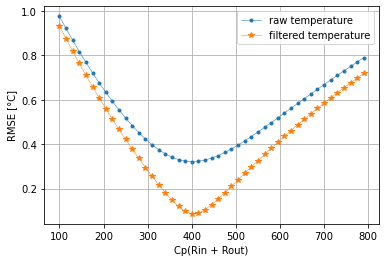

In [29]:
plt.plot(DENOMINATOR, RMSE_raw, marker='.', linewidth=0.5, label='raw temperature')
plt.plot(DENOMINATOR, RMSE_filtered, marker='*', linewidth=0.5, label='filtered temperature')
plt.ylabel('RMSE [°C]')
plt.xlabel('Cp(Rin + Rout)')
plt.legend()
plt.grid()

Now let's evaluate how much the window size of the filtered data influences the final output of the least squares optimization:

AVG_SURFACE_TEMP = 29.238 [°C]
average Q_GEN = 1.267 [W]


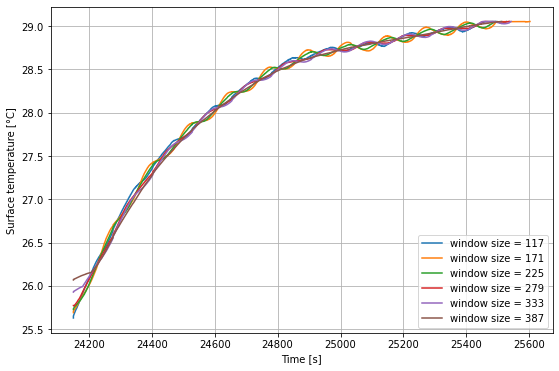

In [67]:
%run DataParse.py
%run DataSection.py
AVG_SURFACE_TEMP = DataSection().calculate_AVG_SURFACE_TEMP(final_section_data)
AVG_Q_GEN = DataParse().calculate_AVG_Q_GEN(final_section_data, 3.82)
opt_result = []
window_size = []
RMSE = []
initial_temp_delta = []

fig, ax1 = plt.subplots(figsize=(9, 6))
for window in range (90, 400, 9*3):
    if window % 2 != 0:
        window_size.append(window)
        raw_data = DataParse().add_temperature_channels(raw_data, window, 1)
        test_data = DataParse().set_test_data(raw_data, 24150)
        initial_section_data = DataSection().set_initial_section(test_data, 0.95, AVG_SURFACE_TEMP)
        ys = initial_section_data['surface_temp_filtered']
        opt_result.append(DataSection().optimize_equation(ys, initial_section_data, AVG_Q_GEN, R_OUT))
        RMSE.append(np.sqrt(np.mean((initial_section_data['surface_temp_average'] - ys)**2)))
        ax1.plot(initial_section_data['Test_Time(s)'], ys, label='window size = ' + str(window))
        initial_temp_delta.append(initial_section_data['surface_temp_filtered'].iloc[0]
                                - initial_section_data['Aux_Temperature_3(C)'].mean())
    else:
        pass
ax1.legend(loc='lower right')
ax1.set_ylabel('Surface temperature [°C]')
ax1.set_xlabel('Time [s]')
ax1.grid()

As the window size increases, the initial values of temperature are more and more biased towards the previous moving average. The plot below shows the effects of filter window size on the optimized values for Cp(Rin + Rout). It also plots the RMSE which remains more or less constant.

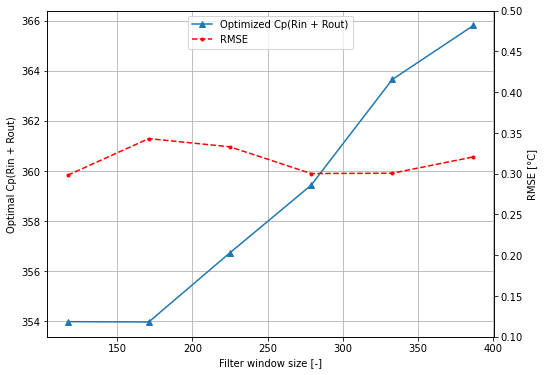

In [72]:
fig, ax1 = plt.subplots(figsize=(8, 6))
ax2 = ax1.twinx()
ax1.plot(window_size, opt_result, marker='^', label='Optimized Cp(Rin + Rout)')
ax1.set_xlabel('Filter window size [-]')
ax1.set_ylabel('Optimal Cp(Rin + Rout)')
ax2.plot(window_size, RMSE, color='red', marker='.', linestyle='--', label='RMSE')
ax2.set_ylabel('RMSE [°C]')
ax2.set_ylim([0.1,0.5])
ax1.grid()
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper center')

Let's plot some of the fitted data against calculared surface temperature using some extreme cases of rolling window to see how the data looks like:

AVG_SURFACE_TEMP = 29.238 [°C]
average Q_GEN = 1.267 [W]


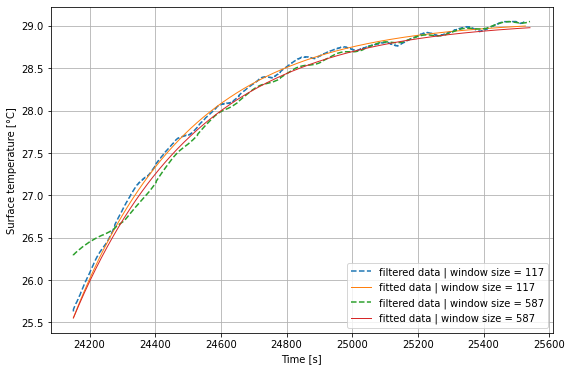

In [96]:
%run DataParse.py
%run DataSection.py
AVG_SURFACE_TEMP = DataSection().calculate_AVG_SURFACE_TEMP(final_section_data)
AVG_Q_GEN = DataParse().calculate_AVG_Q_GEN(final_section_data, 3.82)
window_size = []

fig, ax1 = plt.subplots(figsize=(9, 6))
for window in [117, 587]:
    if window % 2 != 0:
        window_size.append(window)
        raw_data = DataParse().add_temperature_channels(raw_data, window, 1)
        test_data = DataParse().set_test_data(raw_data, 24150)
        initial_section_data = DataSection().set_initial_section(test_data, 0.95, AVG_SURFACE_TEMP)
        ys = initial_section_data['surface_temp_filtered']
        opt_result.append(DataSection().optimize_equation(ys, initial_section_data, AVG_Q_GEN, R_OUT))
        calculated_surface_temp = DataSection().calculate_surface_temp(opt_result[-1], initial_section_data, AVG_Q_GEN, R_OUT)
        ax1.plot(initial_section_data['Test_Time(s)'], ys, 
                 label='filtered data | window size = ' + str(window), linestyle='--')
        ax1.plot(initial_section_data['Test_Time(s)'], calculated_surface_temp, 
                 label='fitted data | window size = ' + str(window), linewidth=1)
    else:
        pass
ax1.legend(loc='lower right')
ax1.set_ylabel('Surface temperature [°C]')
ax1.set_xlabel('Time [s]')
ax1.grid()

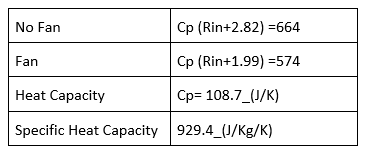

## 3. Heat capacity calculations

If we run for both fan and no fan experiments we get the following results:

In [101]:
Cp, Rin = sp.symbols('Cp, Rin')

Eq1 = sp.Eq(Cp * (Rin + 2.77), 356.35)
Eq2 = sp.Eq(Cp * (Rin + 1.97), 236.09)
res = sp.solve([Eq1,Eq2], Cp, Rin)
print('heat capacity =', round(res[0][0], 3), '[J/K]')
print('specifict heat capacity =', round(res[0][0]/0.114), '[J/kgK]')


heat capacity = 150.325 [J/K]
specifict heat capacity = 1319 [J/kgK]
